<a href="https://colab.research.google.com/github/Akshay1954/JPY-INR-ExchangeRate-Forecasting-LSTM/blob/main/JPY_INR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
tickers = ['JPYINR=X']
df = yf.Ticker(tickers[0]).history(period='2y', interval='1h')
df.head()
df = df.drop(['High', 'Low', 'Open','Volume','Dividends', 'Stock Splits'], axis=1)
df

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
len(scaled_data)

10730

In [ ]:
X = []
Y = []

window_size = 168
features = df.shape[1]

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size: i])
    Y.append(scaled_data[i])

print(len(X))
print(len(scaled_data))

10562
10730


In [ ]:
X = np.array(X)
Y = np.array(Y)

# Splitting the data into train data validation data and test data
train_size = int(len(X) * 0.6)
valid_size = int(len(X) * 0.2)
test_size = len(X) - train_size - valid_size
X_train, X_val, X_test = X[:train_size], X[train_size:train_size+valid_size], X[train_size+valid_size:]
Y_train, Y_val, Y_test = Y[:train_size], Y[train_size:train_size+valid_size], Y[train_size+valid_size:]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)


(6337, 168, 1)
(2112, 168, 1)
(2113, 168, 1)
(6337, 1)
(2112, 1)
(2113, 1)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

stopper = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='auto',
    restore_best_weights=True
)

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(window_size, features), kernel_regularizer=regularizers.L2(l2=0.003)))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=False, kernel_regularizer=regularizers.L2(l2=0.003)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_val, Y_val), callbacks=[stopper])

Epoch 1/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 119s 578ms/step - loss: 0.2765 - val_loss: 0.0095
Epoch 2/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 117s 588ms/step - loss: 0.0063 - val_loss: 0.0043
Epoch 3/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 152s 639ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 4/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 146s 658ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 5/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 129s 592ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 6/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 143s 597ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 147s 624ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 8/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 126s 631ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 9/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 140s 627ms/step - loss: 0.0015 - val_loss: 8.2416e-04
Epoch 10/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 114s 571ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 11/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 154s 632ms/step - loss: 0.0015 - val_loss: 9.1333e-04


In [ ]:
predicted = model.predict(X_test)
predicted = predicted.reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(Y_test)
predicted_prices

67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step


array([[0.589107 ],
       [0.5886355],
       [0.5880383],
       ...,
       [0.5926211],
       [0.5926696],
       [0.5928525]], dtype=float32)

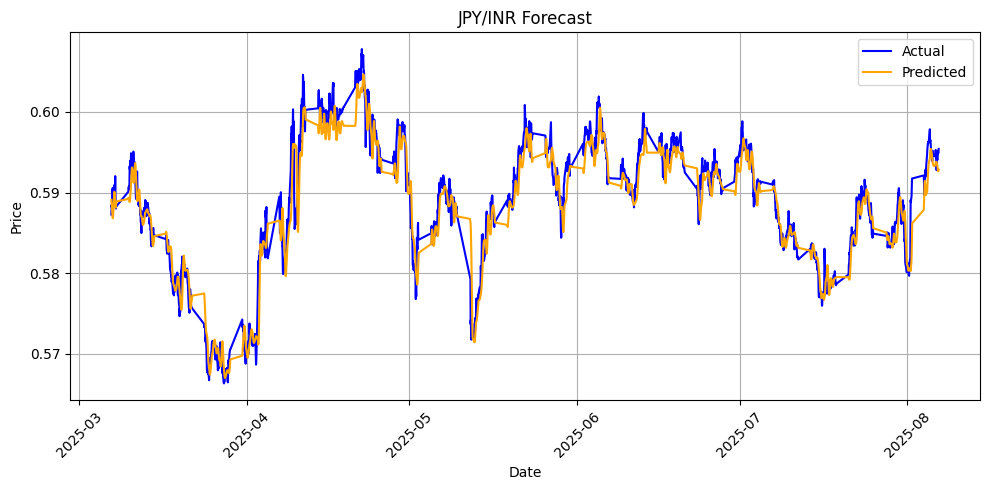

In [ ]:
# Corrected starting index for test dates
test_start_idx = len(X_train) + len(X_val) + 168# The dates for the test set start after the training and validation sets
dates_test = df.index[test_start_idx:]  # these are actual test dates
# dates_test.reshape(-1,1)
import matplotlib.pyplot as plt

# print(len(dates_test))
# print(len(actual_prices))
# print(len(predicted_prices))
plt.figure(figsize=(10, 5))
plt.plot(dates_test, actual_prices, label='Actual', color='blue')
plt.plot(dates_test, predicted_prices, label='Predicted', color='orange') # Reshape predicted_prices
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("JPY/INR Forecast")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# test_start_idx

In [ ]:
future_predictions = []
last_168_hours = scaled_data[-window_size:]

# Correct the input_sequence to be a 2D array with shape (168, 1)
input_sequence = last_168_hours.reshape(window_size, features)

for _ in range(168):
    # Reshape the input_sequence to (1, 168, 1) for the model
    prediction = model.predict(input_sequence.reshape(1, window_size, features))

    # The prediction output is (1, 168, 1) because of return_sequences=True.
    # We only need the prediction for the next step, which is the last element.
    # We also need to flatten it to a single value.
    next_step_prediction = prediction[0][-1]

    # Append the single value prediction to our list
    future_predictions.append(next_step_prediction)

    # Update the input sequence by removing the first element and adding the new prediction
    input_sequence = np.append(input_sequence[1:], [[next_step_prediction]], axis=0)

future_predictions = np.array(future_predictions).reshape(-1, 1)
print(future_predictions.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1

In [ ]:
future_price = scaler.inverse_transform(future_predictions)
future_price

array([[0.5931428 ],
       [0.59348285],
       [0.5937861 ],
       [0.5939689 ],
       [0.59397954],
       [0.59381485],
       [0.59351844],
       [0.5931622 ],
       [0.59281975],
       [0.59254307],
       [0.59235144],
       [0.592233  ],
       [0.5921569 ],
       [0.5920881 ],
       [0.5920005 ],
       [0.5918831 ],
       [0.5917393 ],
       [0.5915812 ],
       [0.5914222 ],
       [0.5912716 ],
       [0.5911319 ],
       [0.59100044],
       [0.59087175],
       [0.59074175],
       [0.59060895],
       [0.59047514],
       [0.5903439 ],
       [0.5902185 ],
       [0.5901007 ],
       [0.5899897 ],
       [0.5898831 ],
       [0.58977747],
       [0.5896704 ],
       [0.58956087],
       [0.58944935],
       [0.58933747],
       [0.5892273 ],
       [0.5891203 ],
       [0.5890171 ],
       [0.5889174 ],
       [0.58882016],
       [0.5887244 ],
       [0.5886291 ],
       [0.5885341 ],
       [0.5884396 ],
       [0.5883459 ],
       [0.58825356],
       [0.588

In [ ]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=168, freq='H')  # 'H' = Hourly
future_dates

/tmp/ipython-input-596594525.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=168, freq='H')  # 'B' = business day


DatetimeIndex(['2025-08-07 18:00:00+01:00', '2025-08-07 19:00:00+01:00',
               '2025-08-07 20:00:00+01:00', '2025-08-07 21:00:00+01:00',
               '2025-08-07 22:00:00+01:00', '2025-08-07 23:00:00+01:00',
               '2025-08-08 00:00:00+01:00', '2025-08-08 01:00:00+01:00',
               '2025-08-08 02:00:00+01:00', '2025-08-08 03:00:00+01:00',
               ...
               '2025-08-14 08:00:00+01:00', '2025-08-14 09:00:00+01:00',
               '2025-08-14 10:00:00+01:00', '2025-08-14 11:00:00+01:00',
               '2025-08-14 12:00:00+01:00', '2025-08-14 13:00:00+01:00',
               '2025-08-14 14:00:00+01:00', '2025-08-14 15:00:00+01:00',
               '2025-08-14 16:00:00+01:00', '2025-08-14 17:00:00+01:00'],
              dtype='datetime64[ns, Europe/London]', length=168, freq='h')

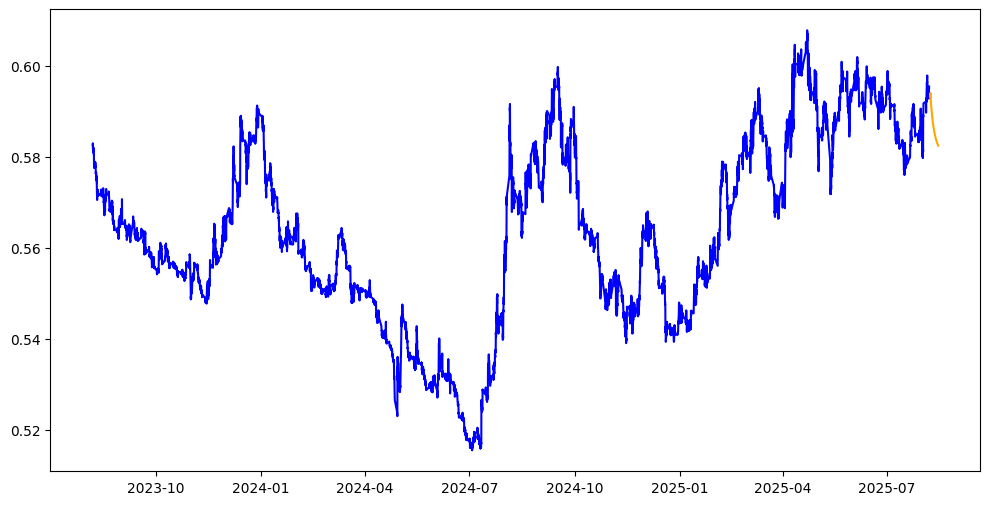

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Historical Price', color='blue')
plt.plot(future_dates, future_price, label='Predicted Price', color='orange')